In [1]:
#os.chdir('/home/lichi/jupiter/imaginarium')
import pandas as pd
import numpy as np
import pickle
import os
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

from lib.gumbel_softmax import gumbel_softmax
from lib.data_preprocessing import get_training_data, pca_transfrom
from lib.model_classes import ImaginariumModel, ImaginariumModelBaseLine
from lib.tools import cyclical_lr, learning_pipeline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'


Populating the interactive namespace from numpy and matplotlib


/home/lichi/venv/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Загружаем данные и сетку


In [13]:
with open('preprocessed_data/words_coco_vectors.pickle', 'rb') as f:
    words_vec = pickle.load(f, encoding='latin1')
with open('preprocessed_data/image_coco_vectors.pickle', 'rb') as f:
    img_vec = pickle.load( f, encoding='latin1')
    

#### Бьем на трейн и тест

In [14]:
words_vec_train = words_vec
words_vec_test = words_vec

img_vec_train = img_vec[:int(img_vec.shape[0]*0.8),:]
img_vec_test = img_vec[int(img_vec.shape[0]*0.8):,:]


### Отрисовываем слова и картинки

In [19]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
params = {
    'num_samples': 500,
    'num_cards': 5,
    'num_words': 998,
    'len_emb': 20,
    'len_dense': 20,
    'num_players':2,
    'gumbel': False,
    'comb_layer': False,
    'img_layer':True,
    'words_layer': False,
    'same_img_words_layer': False
}

model = ImaginariumModel(params)
model_baseline = ImaginariumModelBaseLine(params)

#model_path = 'models/coco/model_50_pca_coco_good.pth'
model_path = 'models/success_imaginarium.pth'
#model_path = 'models/model_50_comb_pca_coco.pth'

model.load_state_dict(torch.load(model_path))
model.eval()

words_vec_train_pca, img_vec_train_pca, words_vec_test_pca, img_vec_test_pca  = pca_transfrom(
    words_vec_train, img_vec_train, words_vec_test, img_vec_test, n_components = params['len_emb'])

X_img_test_origin, y_what_card_leader_choose_test_origin, X_txt_test_origin, _ = get_training_data(
                params, img_vec_test, words_vec_test)
X_img_test_pca, y_what_card_leader_choose_test_pca, X_txt_test_pca, _ = get_training_data(
                params, img_vec_test_pca, words_vec_test_pca)

X_img_train_origin, y_what_card_leader_choose_train_origin, X_txt_train_origin, _ = get_training_data(
                params, img_vec_train, words_vec_train)
X_img_train_pca, y_what_card_leader_choose_train_pca, X_txt_train_pca, _ = get_training_data(
                params, img_vec_train_pca, words_vec_train_pca)


In [62]:
img_vec_train_pca.shape,  words_vec_train_pca.shape

((140, 20), (998, 20))

### Предсказываем веса
##### Origin

In [103]:
X_img_train_origin = torch.FloatTensor([img_vec_train]).permute(1,0,2)
X_txt_train_origin = torch.FloatTensor([words_vec_train]*140)
X_img_train_pca = torch.FloatTensor([img_vec_train_pca]).permute(1,0,2)
X_txt_train_pca = torch.FloatTensor([words_vec_train_pca]*140)

y_what_card_leader_choose_train_origin = torch.FloatTensor([[1]]*140)

weights_train_origin, x_txt_train_origin, x_img_train_origin = model_baseline.get_words_weights(
    X_img_train_origin, X_txt_train_origin, y_what_card_leader_choose_train_origin)
#weights_train_origin, x_txt_train_origin, x_img_train_origin = model_baseline.get_words_weights(
#    X_img_train_origin, X_txt_train_origin, y_what_card_leader_choose_train_origin)

In [104]:
weights_test_origin, x_txt_test_origin, x_img_test_origin = model_baseline.get_words_weights(
    X_img_test_origin, X_txt_test_origin, y_what_card_leader_choose_test_origin)

##### PCA

In [105]:
weights_train_pca, x_txt_train_pca, x_img_train_pca = model_baseline.get_words_weights(
    X_img_train_pca, X_txt_train_pca, y_what_card_leader_choose_train_origin)

#weights_test_pca, x_txt_test_pca, x_img_test_pca = model_baseline.get_words_weights(
#    X_img_test_pca, X_txt_test_pca, y_what_card_leader_choose_test_pca)

##### Network

In [106]:
weights_train_network, x_txt_train_network, x_img_train_network = model.get_words_weights(
    X_img_train_pca, X_txt_train_pca, y_what_card_leader_choose_train_origin)

#weights_test_network, x_txt_test_network, x_img_test_network = model.get_words_weights(
#    X_img_test_pca, X_txt_test_pca, y_what_card_leader_choose_test_pca)

/home/lichi/imaginarium/lib/model_classes.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights_words = self._softmax_words(logits)


In [107]:
weights_train_origin = np.unique(weights_train_origin.detach().numpy(), axis=0)
weights_train_network = np.unique(weights_train_network.detach().numpy(), axis=0)
weights_train_pca = np.unique(weights_train_pca.detach().numpy(), axis=0)

#  Делаем PCA

In [108]:
img_train_network = np.unique(x_img_train_network[:,0,:].detach().numpy(), axis=0)
img_test_network = np.unique(x_img_test_network[:,0,:].detach().numpy(), axis=0)
img_train_pca = np.unique(x_img_train_pca[:,0,:].detach().numpy(), axis=0)
img_test_pca = np.unique(x_img_test_pca[:,0,:].detach().numpy(), axis=0)
img_train_origin = np.unique(x_img_train_origin[:,0,:].detach().numpy(), axis=0)
img_test_origin = np.unique(x_img_test_origin[:,0,:].detach().numpy(), axis=0)


txt_train_network = x_txt_train_network[0,:,:].detach().numpy()
txt_test_network = x_txt_test_network[0,:,:].detach().numpy()
txt_train_pca = x_txt_train_pca[0,:,:].detach().numpy()
txt_test_pca = x_txt_test_pca[:,0,:].detach().numpy()
txt_train_origin = x_txt_train_origin[0,:,:].detach().numpy()
txt_test_origin = x_txt_test_origin[0,:,:].detach().numpy()

In [109]:
pca2_origin = PCA(2)
pca2_network = PCA(2)
pca2_pca = PCA(2)

pca2_origin.fit(np.concatenate([img_train_origin, txt_train_origin]))
pca2_network.fit(np.concatenate([img_train_network, txt_train_network]))
#pca2_pca.fit(np.concatenate([img_train_pca, txt_train_pca]))                           
pca2_pca.fit(np.concatenate([img_vec_train_pca, words_vec_train_pca]))  

    
img_train_origin2, txt_train_origin2 = \
                pca2_origin.transform(img_train_origin), pca2_origin.transform(txt_train_origin)

img_train_network2, txt_train_network2 = \
                pca2_network.transform(img_train_network), pca2_network.transform(txt_train_network)

#img_train_pca2, txt_train_pca2 = \
#                pca2_pca.transform(img_train_pca), pca2_pca.transform(txt_train_pca)

img_train_pca2, txt_train_pca2 = \
                pca2_pca.transform(img_vec_train_pca), pca2_pca.transform(words_vec_train_pca)


### Картинка

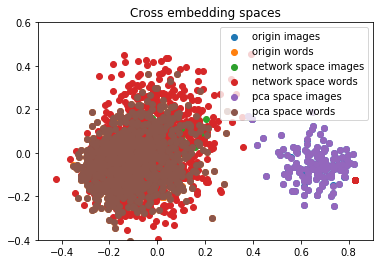

In [110]:
folder = '2_players/'
title = 'Cross embedding spaces'

plt.scatter(img_train_origin2[:,0], img_train_origin2[:,1],
         label = 'origin images')
plt.scatter(txt_train_origin2[:,0], txt_train_origin2[:,1],
         label = 'origin words')

plt.scatter(img_train_network2[:,0], img_train_network2[:,1], 
        label = 'network space images')
plt.scatter(txt_train_network2[:,0], txt_train_network2[:,1],
        label = 'network space words')

plt.scatter(img_train_pca2[:,0], img_train_pca2[:,1],
        label = 'pca space images')
plt.scatter(txt_train_pca2[:,0], txt_train_pca2[:,1],
        label = 'pca space words')

plt.legend()
plt.ylim((-0.4, 0.6))
plt.title(title)

savefig('pictures/{0}/{1}.png'.format(folder, title))


### Предсказываем вес слов

In [ ]:
img_vec_train.shape

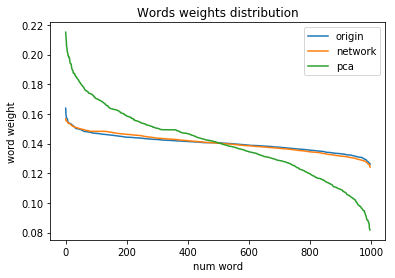

In [111]:
title = 'Words weights distribution'
array_probs = (np.sort(weights_train_origin.sum(axis=0))[::-1])
stat_for_plot_origin = array_probs #/ max(array_probs)
array_probs = (np.sort(weights_train_network.sum(axis=0))[::-1])
stat_for_plot_network = array_probs #/ max(array_probs)
array_probs = (np.sort(weights_train_pca.sum(axis=0))[::-1])
stat_for_plot_pca = array_probs #/ max(array_probs)

plt.plot(range(len(stat_for_plot_origin)), stat_for_plot_origin, label = 'origin')
plt.plot(range(len(stat_for_plot_network)), stat_for_plot_network, label = 'network')
plt.plot(range(len(stat_for_plot_pca)), stat_for_plot_pca, label = 'pca')
plt.legend()
plt.title(title)
plt.xlabel('num word')
plt.ylabel('word weight')

savefig('pictures/{0}/{1}.png'.format(folder, title))

### Делаем удобную табличку индексов

In [130]:
df_index = pd.DataFrame({
    'ind': range(weights_train_network.shape[1]),
    'weight_network': np.mean(weights_train_network, axis = 0),
    'weight_pca': np.mean(weights_train_pca, axis = 0),
    'weight_origin': np.mean(weights_train_origin, axis = 0),
    
})

### Смотрим семантику слов

In [127]:
table_semantic_1000 = pd.read_csv('data/words/words1000_semantics.csv')
table_semantic_4000 = pd.read_csv('data/words/words4000_semantics.csv')
table_semantic = table_semantic_1000.merge(df_index, left_on = 'ind', right_on = 'ind').drop_duplicates(
    'word').reset_index(drop=True)
#words = pd.read_csv('data/words/raw/top1000_words.txt', sep = ',', header = -1).T[0]
#words = np.array([x.replace(' ', '') for x in words])

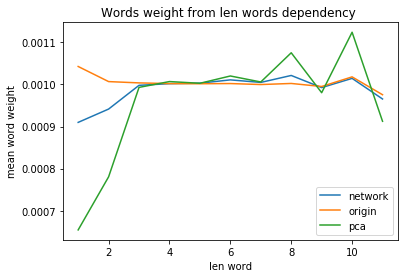

In [149]:
title = 'Words weight from len words dependency '
plt.rcParams['figure.figsize'] = 6, 4
table_semantic['len_word'] = table_semantic['word'].apply(lambda x: len(x))
df = table_semantic.groupby('len_word').mean()
plt.plot(df.index, df['weight_network'], label = 'network')
plt.plot(df.index, df['weight_origin'], label = 'origin')
plt.plot(df.index, df['weight_pca'], label = 'pca')
plt.legend()
plt.title(title)
plt.xlabel('len word')
plt.ylabel('mean word weight')

savefig('pictures/{0}/{1}.png'.format(folder, title))

### Смотрим на Часть речи

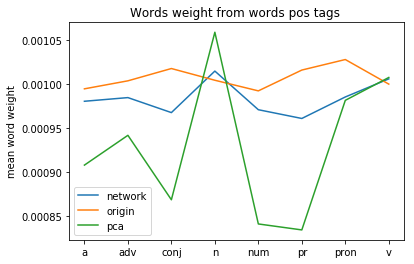

In [150]:
title = 'Words weight from words pos tags '

df = table_semantic.groupby('pos').mean()
plt.plot(df.index, df['weight_network'], label = 'network')
plt.plot(df.index, df['weight_origin'], label = 'origin')
plt.plot(df.index, df['weight_pca'], label = 'pca')
plt.legend()
plt.title(title)
#plt.xlabel('len word')
plt.ylabel('mean word weight')
savefig('pictures/{0}/{1}.png'.format(folder, title))

### Концепты слов

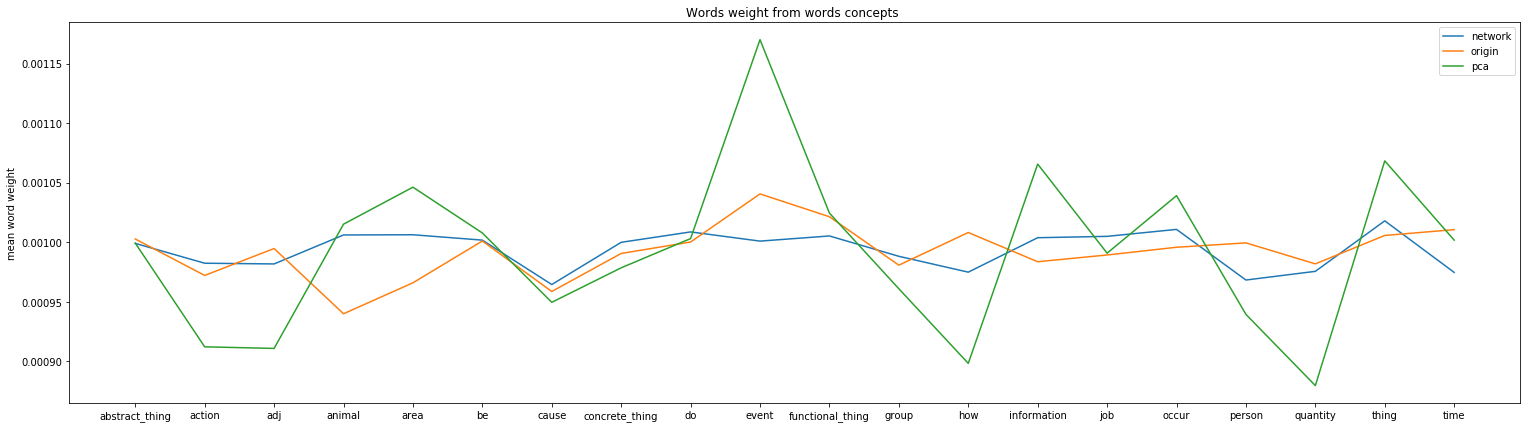

In [152]:
plt.rcParams['figure.figsize'] = 26, 7

title = 'Words weight from words concepts '

df = table_semantic.groupby('concept').mean()
plt.plot(df.index, df['weight_network'], label = 'network')
plt.plot(df.index, df['weight_origin'], label = 'origin')
plt.plot(df.index, df['weight_pca'], label = 'pca')
plt.legend()
plt.title(title)
#plt.xlabel('len word')
plt.ylabel('mean word weight')
savefig('pictures/{0}/{1}.png'.format(folder, title))


In [ ]:
значимость - оценить бутстепом 




### Шапка для картинок

In [ ]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


In [19]:
def get_words_weight(x_img, x_txt, gumbel = False):
    distance1axis = torch.nn.modules.distance.CosineSimilarity(dim = 1)
    softmax = torch.nn.Softmax()
    x_img_output = [x_img for ind in range(x_txt.shape[0])]
    x_img_output = np.array(x_img_output)
    logits = distance1axis(torch.FloatTensor(x_img_output), torch.FloatTensor(x_txt))
    ### Веса для слов (Гумбель) или классика
    if gumbel:
        weights_words = gumbel_softmax(logits, hard = True)
    else:
        weights_words = softmax(logits)
    return weights_words